In [1]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import xgboost as xgb
from shapely.wkt import loads
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- NEW: Suppress all warnings for a clean final output ---
warnings.filterwarnings('ignore')


# --- Step 1: Mount Drive and Load Data ---
drive.mount('/content/drive', force_remount=True)
base_path = '/content/drive/My Drive/MIAI_Project/data/'
calgary_file = 'Total_Property_Assessed_Value.csv'
# Added low_memory=False to help with the DtypeWarning
calgary_df = pd.read_csv(base_path + calgary_file, low_memory=False)


# --- Step 2: Clean and Prepare Property Data ---
residential_df = calgary_df[calgary_df['ASSESSMENT_CLASS_DESCRIPTION'] == 'Residential'].copy()
columns_to_clean = ['ASSESSED_VALUE', 'LAND_SIZE_SM']
for col in columns_to_clean:
    if residential_df[col].dtype == 'object':
        residential_df[col] = residential_df[col].str.replace(',', '')
    residential_df[col] = pd.to_numeric(residential_df[col], errors='coerce')


# --- Step 3: Create Coordinate Features ---
def get_centroid(polygon_wkt):
    try:
        polygon = loads(polygon_wkt)
        return polygon.centroid.x, polygon.centroid.y
    except:
        return None, None
centroids = residential_df['MULTIPOLYGON'].apply(get_centroid)
residential_df['longitude'] = centroids.apply(lambda x: x[0])
residential_df['latitude'] = centroids.apply(lambda x: x[1])


# --- Step 4: Select Final Features, Clean, and Filter Outliers ---
features_to_use = [
    'YEAR_OF_CONSTRUCTION', 'LAND_SIZE_SM', 'ROLL_YEAR',
    'longitude', 'latitude', 'ASSESSED_VALUE'
]
model_df = residential_df[features_to_use].copy()
model_df.dropna(inplace=True)
model_df = model_df[model_df['ASSESSED_VALUE'] < 3000000]


# --- Step 5: Define Features and Target ---
X = model_df.drop('ASSESSED_VALUE', axis=1)
y = model_df['ASSESSED_VALUE']


# --- Step 6: Split the Data and Train Model ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgbr = xgb.XGBRegressor(n_estimators=100, max_depth=5, objective='reg:squarederror', random_state=42, device="cuda")
xgbr.fit(X_train, y_train)


# --- Step 7: Evaluate on BOTH Train and Test Sets ---
predictions_test = xgbr.predict(X_test)
predictions_train = xgbr.predict(X_train)
score_r2_test = r2_score(y_test, predictions_test)
score_mae_test = mean_absolute_error(y_test, predictions_test)
score_rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
score_r2_train = r2_score(y_train, predictions_train)
score_mae_train = mean_absolute_error(y_train, predictions_train)
score_rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))


# --- Step 8: Print Final, Clean Report ---
print("--- Final Model Performance ---")
print("\n--- Test Set (Unseen Data) ---")
print(f"R-squared: {score_r2_test:.2f}")
print(f"MAE: ${score_mae_test:,.2f}")
print(f"RMSE: ${score_rmse_test:,.2f}")
print("\n--- Train Set (Seen Data) ---")
print(f"R-squared: {score_r2_train:.2f}")
print(f"MAE: ${score_mae_train:,.2f}")
print(f"RMSE: ${score_rmse_train:,.2f}")
print("-----------------------------")

Mounted at /content/drive
--- Final Model Performance ---

--- Test Set (Unseen Data) ---
R-squared: 0.73
MAE: $91,940.28
RMSE: $156,499.15

--- Train Set (Seen Data) ---
R-squared: 0.73
MAE: $91,661.78
RMSE: $155,673.06
-----------------------------


In [2]:
# Create the DataFrame just before the outlier filter is applied
features_to_use = [
    'YEAR_OF_CONSTRUCTION',
    'LAND_SIZE_SM',
    'ROLL_YEAR',
    'longitude',
    'latitude',
    'ASSESSED_VALUE'
]
df_before_filter = residential_df[features_to_use].copy()
df_before_filter.dropna(inplace=True)

# Get the number of rows BEFORE filtering
rows_before = len(df_before_filter)

# Apply the filter to get the number of rows AFTER
df_after_filter = df_before_filter[df_before_filter['ASSESSED_VALUE'] < 3000000]
rows_after = len(df_after_filter)

# Calculate and print the difference
outliers_removed = rows_before - rows_after
percentage_removed = (outliers_removed / rows_before) * 100

print(f"Total rows before filtering: {rows_before:,}")
print(f"Total rows after filtering: {rows_after:,}")
print(f"Number of outlier properties removed: {outliers_removed:,}")
print(f"Percentage of data removed: {percentage_removed:.2f}%")

Total rows before filtering: 2,116,966
Total rows after filtering: 2,111,397
Number of outlier properties removed: 5,569
Percentage of data removed: 0.26%


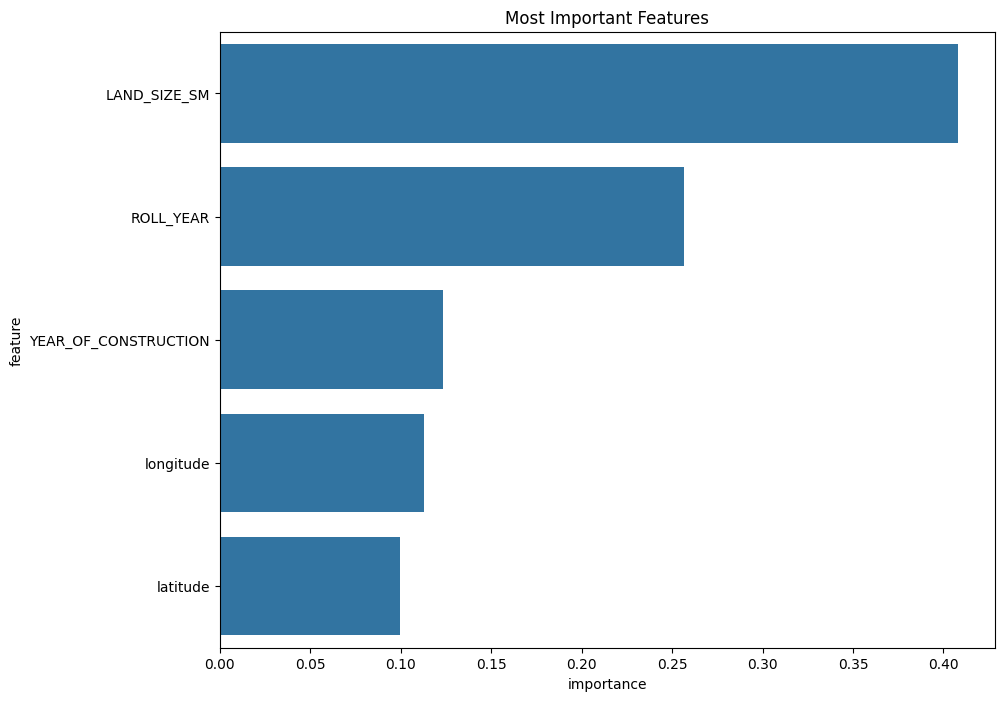

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importances from the trained model
importances = xgbr.feature_importances_
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Most Important Features')
plt.show()

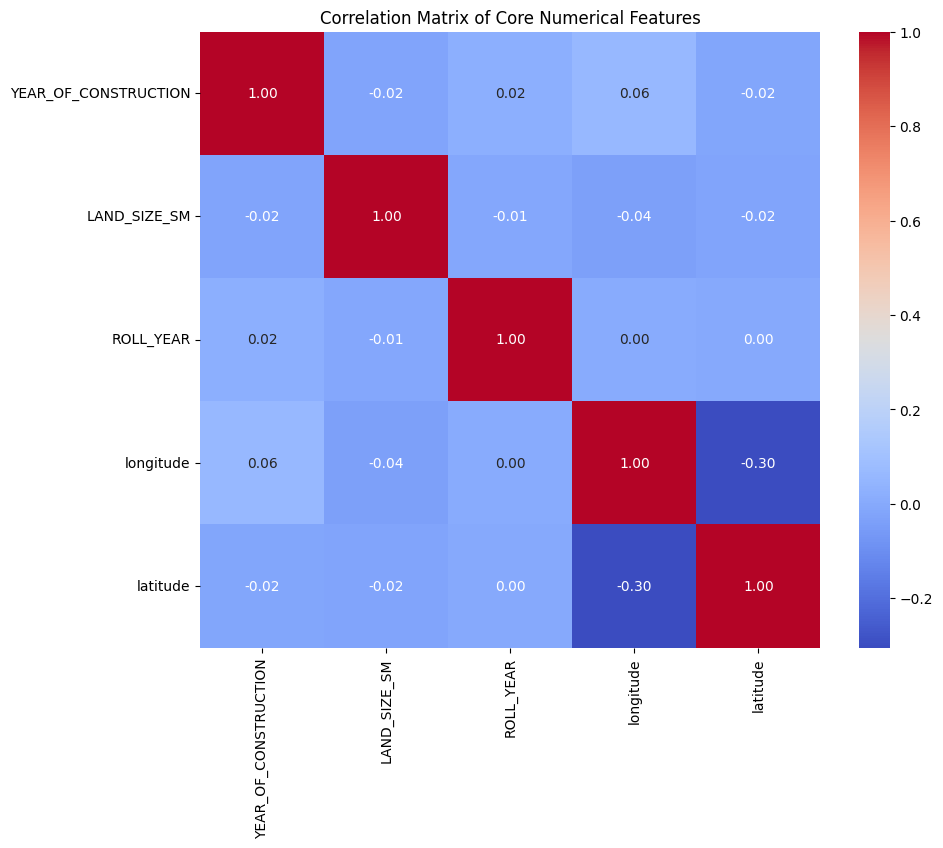

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# We will use model_df before it was one-hot encoded to see the core relationships
# We drop the target variable as we only want to see correlations between independent variables
features_for_corr = model_df.drop('ASSESSED_VALUE', axis=1)

# Calculate the correlation matrix
corr_matrix = features_for_corr.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Core Numerical Features')
plt.show()